In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

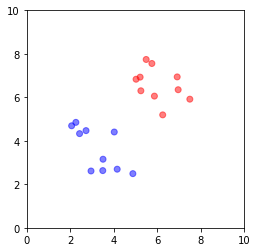

In [2]:
np.random.seed(4843750)

nums = 10
x1 = np.random.rand(nums, 2) * 3 + 2
x2 = np.random.rand(nums, 2) * 3 + 5
x = np.concatenate([x1, x2])
y = np.array([-1]*nums + [1]*nums)

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.5)
plt.axis('scaled')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()

In [3]:
class SVM(object):
    def __init__(self, x, y, c, tol, iters):
        self.x = x
        self.y = y
        self.c = c
        self.tol = tol
        self.iters = iters
        self.alphas = np.zeros(x.shape[0])
        self.weights = np.zeros(x.shape[1])
        self.bias = 0 
        return
    
    def kernel(self, xi, xj):
        res = np.dot(xi, xj) 
        # res = np.power(xi-xj, 2).sum() 
        return res
    
    def compute_gi(self, i):
        xi, gi = self.x[i], 0
        for j in range(len(self.alphas)):
            yj, aj, xj = self.y[j], self.alphas[j], self.x[j]
            gi += yj*aj*self.kernel(xi, xj)
        gi += self.bias
        return gi
    
    def compute_ei(self, i):
        ei = self.compute_gi(i) - self.y[i] 
        return ei
    
    def compute_grand(self, i, j):
        xi, xj = self.x[i], self.x[j]
        kij = self.kernel(xi, xj)
        return kij
    
    def select_j_random(self, i):
        j = i
        while j==i:
            j = int(np.random.uniform(0, len(self.alphas)))
        return j
    
    def compute_L_H(self, ai, aj, yi, yj):
        if yi!=yj:
            L = max(0, aj - ai)
            H = min(self.c, self.c + aj - ai)
        else:
            L = max(0, aj + ai - self.c)
            H = min(self.c, aj + ai)
        return L, H
    
    def clip_alphas(self, aj_new, L, H):
        if aj_new <= L:
            aj_new = L
        elif aj_new >= H:
            aj_new = H
        return aj_new
    
    def clip_bias(self, ai_new, aj_new, bi, bj):
        b = None
        if 0 < ai_new < self.c:
                b = bi
        elif 0 < aj_new < self.c:
            b = bj
        else:
            b = (bi + bj)/2
        return b
    
    def is_violate_kkt(self, i):
        ai = self.alphas[i]
        yi = self.y[i]
        gi = self.compute_gi(i)
        c = self.c
        if (0<ai<c) and (yi*gi!=1):
            return True
        if (ai==c) and (yi*gi>1):
            return True
        if (ai==0) and (yi*gi<1):
            return True
        return False
    
    def select_i_violate_kkt(self):
        cands = list(range(len(self.alphas)))
        np.random.shuffle(cands)
        for i in cands:
            ai = self.alphas[i]
            yi = self.y[i]
            gi = self.compute_gi(i)
            c = self.c
            if (0<ai<c) and (yi*gi!=1):
                return i
        for i in cands:
            ai = self.alphas[i]
            yi = self.y[i]
            gi = self.compute_gi(i)
            c = self.c
            if (ai==c) and (yi*gi>1):
                return i   
        for i in cands:
            ai = self.alphas[i]
            yi = self.y[i]
            gi = self.compute_gi(i)
            c = self.c
            if (ai==0) and (yi*gi<1):
                return i
        return None
    
    def select_j_from_i(self, i):
        ei = self.compute_ei(i)
        e_max = 0
        j_res = None
        for j in range(len(self.alphas)):
            if j==i:
                continue
            if self.is_violate_kkt(j) is False:
                continue
            else:
                ej = self.compute_ei(j)
                if np.abs(ei - ej) >= e_max:
                    e_max = np.abs(ei - ej)
                    j_res = j
        return j_res
                
    
    def platt_smo(self):
        i = self.select_i_violate_kkt()
        if i is None:
            return 
        j = self.select_j_from_i(i) 
        if j is None:
            return
        ai, aj = self.alphas[i], self.alphas[j]
        xi, xj = self.x[i], self.x[j]
        yi, yj = self.y[i], self.y[j]
        ei, ej = self.compute_ei(i), self.compute_ei(j)

        k11 = self.compute_grand(i, i)
        k12 = self.compute_grand(i, j)
        k21 = self.compute_grand(j, i)
        k22 = self.compute_grand(j, j)
        eta = k11 - 2*k12 + k22   
        # print((i, j), (k11, k12, k22), eta)

        L, H = self.compute_L_H(ai, aj, yi, yj)
        aj_new = aj + yj*(ei - ej)/eta

        aj_new = self.clip_alphas(aj_new, L, H)
        ai_new = ai + yi*yj*(aj - aj_new)
        # print((i, j), (ai, ai_new), (aj, aj_new))

        # if np.abs(aj_new - aj)< 0.00001:
        #     print("np.abs(aj_new - aj)< 0.00001")
        #     return 
        # print((i, j), (ai, ai_new), (aj, aj_new))

        bi = -ei - yi*k11*(ai_new - ai) - yj*k12*(aj_new - aj) + self.bias
        bj = -ej - yi*k12*(ai_new - ai) - yj*k22*(aj_new - aj) + self.bias
        b_new = self.clip_bias(ai_new, aj_new, bi, bj)
        # print((i, j), (ai, ai_new), (aj, aj_new), (b_new))

        self.alphas[i] = ai_new
        self.alphas[j] = aj_new
        self.bias = b_new
        return
    
    def run_test(self):
        i = self.select_i_violate_kkt()
        j = self.select_j_from_i(i)
        return j
    
    def run(self):
        for loop in range(self.iters):
            self.platt_smo()
        for i in range(len(self.alphas)):
            self.weights += self.alphas[i] * self.y[i] * self.x[i]
        self.alphas = np.round(self.alphas, 3)
        return
    pass 

svm = SVM(x, y, c=10.0, tol=0.01, iters=100)
svm.run()

print(svm.weights, svm.bias)
print(svm.alphas)

[0.67980069 0.616218  ] -6.448660693188048
[0.421 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.164 0.257 0.   ]


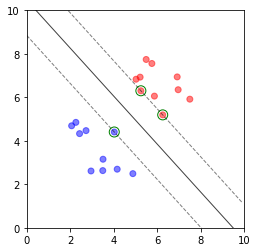

In [4]:
xt = np.arange(0, 10, 0.1)
yt = (-svm.bias - xt*svm.weights[0])/svm.weights[1]
yt1 = (-svm.bias - 1 - xt*svm.weights[0])/svm.weights[1]
yt2 = (-svm.bias + 1 - xt*svm.weights[0])/svm.weights[1]

plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.5)
for i in range(len(svm.alphas)):
    if svm.alphas[i]>0:
        plt.scatter(x[i:i+1, 0], x[i:i+1, 1], c='None', edgecolors='green', s=100)
plt.plot(xt, yt , c='black', linestyle='-' , linewidth=1, alpha=0.75)
plt.plot(xt, yt1, c='black', linestyle='--', linewidth=1, alpha=0.50)
plt.plot(xt, yt2, c='black', linestyle='--', linewidth=1, alpha=0.50)
plt.axis('scaled')
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.show()